In [1]:
import pandas as pd
import numpy as np

import torch
import pathlib
import random
import cv2
import gc
import sys
import matplotlib.pyplot as plt
from collections import Counter

import solt as sl
import solt.transforms as slt
import sklearn.model_selection as ms
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from torch import nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import torch.optim as optim

import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import time
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device}')

Using cpu


In [2]:
base_path = "C:/Users/anush/OneDrive/Documents/Sem3/AI in Health Technology/Project/"

In [3]:
data = pd.read_csv("data_asDownloaded/train.csv")

In [4]:
data

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0
...,...,...
2925,e4a44f9158dc,0
2926,e4ae1ee6aada,0
2927,e4b0df29b96f,0
2928,e4c799738a19,0


In [5]:
data_aug = pd.read_csv("data_augmented/train_augmented.csv")

In [6]:
data_aug

,CLASS,PATH,LABEL
0,0,train_augmented\0\7828dd083cdc.png,0
1,0,train_augmented\0\881ec6186e68.png,0
2,3,train_augmented\3\6253f23229b1_8.png,3
3,3,train_augmented\3\9878db94d9f3_2.png,3
4,0,train_augmented\0\8b079e79035f.png,0
...,...,...,...
7877,0,train_augmented\0\e42d9a94a66d.png,0
7878,4,train_augmented\4\df4aec4a0eaf_4.png,4
7879,4,train_augmented\4\9a496b1e20f9.png,4
7880,3,train_augmented\3\4294a14c656a_2.png,3


In [7]:
dg_list = data_aug['LABEL'].to_list()
freq = Counter(dg_list)
freq

Counter({0: 1434, 3: 1694, 1: 1500, 2: 1616, 4: 1638})

In [8]:
# Training transforms
def get_train_transform(pretrained=True):
    train_transform = transforms.Compose([
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ColorJitter(brightness=(1.4, 1.6), contrast=(1.5,2)),
        transforms.Resize((380, 380)),
        transforms.ToTensor(),
        normalize_transform()
    ])
    return train_transform


# Validation transforms
def get_valid_transform(pretrained=True):
    valid_transform = transforms.Compose([
        transforms.Resize((380, 380)),
        transforms.ToTensor(),
        normalize_transform()
    ])
    return valid_transform


# Image normalization transforms.
def normalize_transform():
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    return normalize

In [27]:
def get_datasets(pretrained=True):
    """
        Function to prepare the Datasets.
        :param pretrained: Boolean, True or False.
        Returns the training, validation and testing datasets along 
        with the class names.
    """
    dataset_train = datasets.ImageFolder(
        base_path+"/data_augmented/train_augmented", 
        transform=(get_train_transform(pretrained=True))
    )
    dataset_val = datasets.ImageFolder(
        base_path+"/data/valid", 
        transform=(get_valid_transform(pretrained=True))
    )
    dataset_test = datasets.ImageFolder(
        base_path+"/data/test", 
        transform=(get_valid_transform(pretrained=True))
    )
    return dataset_train, dataset_val, dataset_test, dataset_train.classes

def get_data_loaders(dataset_train, dataset_valid, dataset_test, BATCH_SIZE=8):
    """
    Prepares the training and validation data loaders.
    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.
    :param dataset_test: The test dataset.
    Returns the training, validation and testing data loaders.
    """
    train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE)
    valid_loader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, valid_loader, test_loader

In [10]:
def get_transformed_test_datasets(pretrained=True):
    dataset_val_transformed = datasets.ImageFolder(
        base_path+"/data/valid", 
        transform=(get_train_transform(pretrained=True))
    )
    dataset_test_transformed = datasets.ImageFolder(
        base_path+"/data/test", 
        transform=(get_train_transform(pretrained=True))
    )
    return dataset_val_transformed, dataset_test_transformed

def get_transformed_data_loaders(dataset_val_transformed, dataset_test_transformed, BATCH_SIZE=8):
    valid_loader = DataLoader(dataset_val_transformed, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(dataset_test_transformed, batch_size=BATCH_SIZE, shuffle=False)
    return valid_loader, test_loader

In [11]:
dataset_train, dataset_valid, dataset_test, dataset_classes = get_datasets(True)
train_loader, valid_loader, test_loader = get_data_loaders(dataset_train, dataset_valid, dataset_test)

In [12]:
dataset_val_transformed, dataset_test_transformed = get_transformed_test_datasets()
valid_loader_transformed, test_loader_transformed = get_transformed_data_loaders(dataset_val_transformed, dataset_test_transformed)

In [13]:
len(train_loader)

986

In [14]:
model = models.efficientnet_b4(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

#For no finetuning-> Freezing model weights
for params in model.parameters():
    params.requires_grad = False
    
model.classifier = nn.Sequential(nn.Flatten(),
                                 nn.Linear(1792, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(256, 5))

In [15]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

18,008,909 total parameters.
460,293 training parameters.


In [16]:
# Optimizer:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Loss function:
criterion = nn.CrossEntropyLoss()

In [17]:
def train(model, trainloader, optimizer, criterion, epochNum):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    list_preds = []
    list_labels = []
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        list_preds.append(preds)
        list_labels.append(labels)
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
        
    torch.save(model, base_path+f"/efficientnet_b4_dup_augData/model_checkpoint_{epochNum}.pt")
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    
    #for balanced accuracy
    list_true = []
    for i in range(len(list_labels)):
        for j in range(0, list_labels[i].shape[0]):
            list_true.append(int(list_labels[i][j]))

    list_pred = []
    for i in range(len(list_preds)):
        for j in range(0, list_preds[i].shape[0]):
            list_pred.append(int(list_preds[i][j]))
            
    balanced_acc = balanced_accuracy_score(list_true, list_pred)
    
    return epoch_loss, epoch_acc, balanced_acc

In [18]:
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    list_preds = []
    list_labels = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            list_preds.append(preds)
            list_labels.append(labels)
            
            
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    
    #for balanced accuracy
    list_true = []
    for i in range(len(list_labels)):
        for j in range(0, list_labels[i].shape[0]):
            list_true.append(int(list_labels[i][j]))

    list_pred = []
    for i in range(len(list_preds)):
        for j in range(0, list_preds[i].shape[0]):
            list_pred.append(int(list_preds[i][j]))
            
    balanced_acc = balanced_accuracy_score(list_true, list_pred)
    return epoch_loss, epoch_acc, balanced_acc

In [19]:
epochs = 20
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc, train_bacc = train(model, train_loader, optimizer, criterion, epoch)
    valid_epoch_loss, valid_epoch_acc, valid_bacc = validate(model, valid_loader, criterion)
    valid_epoch_loss_TF, valid_epoch_acc_TF, valid_bacc_TF = validate(model, valid_loader_transformed, criterion)
    
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}, training BACC: {train_bacc:.3f}")
    print(f"Valid loss: {valid_epoch_loss:.3f}, valid acc: {valid_epoch_acc:.3f}, valid BACC: {valid_bacc:.3f}")
    print(f"Valid loss TF: {valid_epoch_loss_TF:.3f}, valid acc TF: {valid_epoch_acc_TF:.3f}, valid BACC TF: {valid_bacc_TF:.3f}")
    print('-'*50)
    time.sleep(5)

[INFO]: Epoch 1 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:43:27<00:00,  6.30s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:44<00:00,  3.58s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:58<00:00,  5.19s/it]


Training loss: 0.648, training acc: 89.787, training BACC: 0.901
Valid loss: 13.325, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 13.330, valid acc TF: 7.650, valid BACC TF: 0.200
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:42:05<00:00,  6.21s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:45<00:00,  3.60s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:58<00:00,  5.18s/it]


Training loss: 1.007, training acc: 84.040, training BACC: 0.840
Valid loss: 16.582, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 16.257, valid acc TF: 7.650, valid BACC TF: 0.200
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:41:03<00:00,  6.15s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:34<00:00,  3.36s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:59<00:00,  5.21s/it]


Training loss: 1.111, training acc: 81.299, training BACC: 0.816
Valid loss: 13.637, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 13.782, valid acc TF: 7.650, valid BACC TF: 0.200
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:40:39<00:00,  6.13s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:44<00:00,  3.59s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [04:00<00:00,  5.24s/it]


Training loss: 0.823, training acc: 86.983, training BACC: 0.871
Valid loss: 10.214, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 10.184, valid acc TF: 7.650, valid BACC TF: 0.200
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:41:35<00:00,  6.18s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:45<00:00,  3.60s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:59<00:00,  5.20s/it]


Training loss: 0.730, training acc: 85.004, training BACC: 0.852
Valid loss: 10.462, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 10.346, valid acc TF: 7.650, valid BACC TF: 0.200
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:41:31<00:00,  6.18s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:35<00:00,  3.39s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:59<00:00,  5.21s/it]


Training loss: 0.749, training acc: 87.757, training BACC: 0.878
Valid loss: 10.078, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 9.966, valid acc TF: 7.650, valid BACC TF: 0.200
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:41:43<00:00,  6.19s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:45<00:00,  3.60s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:56<00:00,  5.15s/it]


Training loss: 0.686, training acc: 87.782, training BACC: 0.879
Valid loss: 15.706, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 15.261, valid acc TF: 7.650, valid BACC TF: 0.200
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:41:14<00:00,  6.16s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:45<00:00,  3.59s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:59<00:00,  5.21s/it]


Training loss: 0.735, training acc: 88.493, training BACC: 0.886
Valid loss: 13.140, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 12.802, valid acc TF: 7.650, valid BACC TF: 0.200
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:39:33<00:00,  6.06s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:38<00:00,  3.45s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:52<00:00,  5.06s/it]


Training loss: 0.618, training acc: 87.909, training BACC: 0.880
Valid loss: 11.552, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 11.097, valid acc TF: 7.650, valid BACC TF: 0.200
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:38:50<00:00,  6.01s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:44<00:00,  3.57s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:56<00:00,  5.13s/it]


Training loss: 0.614, training acc: 87.338, training BACC: 0.874
Valid loss: 10.551, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 9.785, valid acc TF: 7.650, valid BACC TF: 0.200
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:39:46<00:00,  6.07s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:37<00:00,  3.43s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:49<00:00,  5.00s/it]


Training loss: 0.573, training acc: 89.305, training BACC: 0.894
Valid loss: 12.152, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 11.254, valid acc TF: 7.650, valid BACC TF: 0.200
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:39:41<00:00,  6.07s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:32<00:00,  3.31s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:51<00:00,  5.03s/it]


Training loss: 0.504, training acc: 89.926, training BACC: 0.900
Valid loss: 14.861, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 13.710, valid acc TF: 7.650, valid BACC TF: 0.200
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:43:07<00:00,  6.28s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:42<00:00,  3.54s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:56<00:00,  5.14s/it]


Training loss: 0.513, training acc: 89.254, training BACC: 0.894
Valid loss: 11.811, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 11.087, valid acc TF: 8.197, valid BACC TF: 0.202
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


  2%|█▍                                                                             | 18/986 [01:19<1:11:00,  4.40s/it]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\anush\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\anush\AppData\Local\Temp\ipykernel_27624\652801564.py", line 7, in <module>
    train_epoch_loss, train_epoch_acc, train_bacc = train(model, train_loader, optimizer, criterion, epoch)
                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\anush\AppData\Local\Temp\ipykernel_27624\4082515297.py", line 9, in train
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
  File "C:\Users\anush\anaconda3\Lib\site-packages\tqdm\std.py", line 1178, in __iter__
    for obj in iterable:
  File "C:\Users\anush\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py", line 631, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "C:\Users\anush\anaconda3\Lib\site-packages\t

In [22]:
epoch

13

In [21]:
PATH = base_path+f"/efficientnet_b4_dup_augData/model_checkpoint_{12}.pt"
model = torch.load(PATH, weights_only=False)

In [23]:
# Resume the training.
for epoch in range(13, epochs+5):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc, train_bacc = train(model, train_loader, optimizer, criterion, epoch)
    valid_epoch_loss, valid_epoch_acc, valid_bacc = validate(model, valid_loader, criterion)
    valid_epoch_loss_TF, valid_epoch_acc_TF, valid_bacc_TF = validate(model, valid_loader_transformed, criterion)
    
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}, training BACC: {train_bacc:.3f}")
    print(f"Valid loss: {valid_epoch_loss:.3f}, valid acc: {valid_epoch_acc:.3f}, valid BACC: {valid_bacc:.3f}")
    print(f"Valid loss TF: {valid_epoch_loss_TF:.3f}, valid acc TF: {valid_epoch_acc_TF:.3f}, valid BACC TF: {valid_bacc_TF:.3f}")
    print('-'*50)
    time.sleep(5)

[INFO]: Epoch 14 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:59:28<00:00,  7.27s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:32<00:00,  4.62s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [04:36<00:00,  6.01s/it]


Training loss: 10.255, training acc: 26.541, training BACC: 0.263
Valid loss: 10.058, valid acc: 7.923, valid BACC: 0.201
Valid loss TF: 9.038, valid acc TF: 10.383, valid BACC TF: 0.212
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:57:02<00:00,  7.12s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:18<00:00,  4.32s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [04:41<00:00,  6.13s/it]


Training loss: 10.165, training acc: 26.389, training BACC: 0.261
Valid loss: 10.393, valid acc: 7.923, valid BACC: 0.201
Valid loss TF: 9.403, valid acc TF: 9.563, valid BACC TF: 0.208
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:55:20<00:00,  7.02s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:43<00:00,  3.56s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:52<00:00,  5.05s/it]


Training loss: 10.264, training acc: 26.351, training BACC: 0.261
Valid loss: 10.567, valid acc: 7.923, valid BACC: 0.201
Valid loss TF: 9.651, valid acc TF: 10.109, valid BACC TF: 0.210
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:42:20<00:00,  6.23s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:46<00:00,  3.63s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:59<00:00,  5.21s/it]


Training loss: 10.236, training acc: 26.097, training BACC: 0.258
Valid loss: 11.178, valid acc: 7.923, valid BACC: 0.201
Valid loss TF: 10.289, valid acc TF: 9.836, valid BACC TF: 0.209
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:52:40<00:00,  6.86s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:47<00:00,  3.65s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:58<00:00,  5.17s/it]


Training loss: 10.320, training acc: 26.250, training BACC: 0.260
Valid loss: 10.517, valid acc: 7.923, valid BACC: 0.201
Valid loss TF: 9.594, valid acc TF: 10.383, valid BACC TF: 0.212
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:43:44<00:00,  6.31s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:55<00:00,  3.81s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [04:06<00:00,  5.35s/it]


Training loss: 10.141, training acc: 26.846, training BACC: 0.267
Valid loss: 11.134, valid acc: 7.923, valid BACC: 0.201
Valid loss TF: 10.381, valid acc TF: 9.290, valid BACC TF: 0.207
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:44:10<00:00,  6.34s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:52<00:00,  3.75s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [04:01<00:00,  5.24s/it]


Training loss: 10.218, training acc: 26.364, training BACC: 0.261
Valid loss: 11.395, valid acc: 7.650, valid BACC: 0.200
Valid loss TF: 10.564, valid acc TF: 9.016, valid BACC TF: 0.206
--------------------------------------------------
[INFO]: Epoch 21 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:45:05<00:00,  6.40s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:56<00:00,  3.84s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [04:02<00:00,  5.27s/it]


Training loss: 10.310, training acc: 26.440, training BACC: 0.262
Valid loss: 10.471, valid acc: 7.923, valid BACC: 0.201
Valid loss TF: 9.551, valid acc TF: 9.836, valid BACC TF: 0.209
--------------------------------------------------
[INFO]: Epoch 22 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [1:42:55<00:00,  6.26s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:03<00:00,  4.00s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [04:07<00:00,  5.38s/it]


Training loss: 10.284, training acc: 26.351, training BACC: 0.261
Valid loss: 11.131, valid acc: 7.923, valid BACC: 0.201
Valid loss TF: 10.340, valid acc TF: 9.016, valid BACC TF: 0.206
--------------------------------------------------
[INFO]: Epoch 23 of 20
Training


  5%|████▎                                                                          | 54/986 [04:20<1:14:52,  4.82s/it]


KeyboardInterrupt: 

In [25]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, pretrained):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
    plt.plot(valid_acc, color='blue', linestyle='-', label='validataion accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(base_path + f"/outputsa/accuracy_pretrained_{pretrained}.png")
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
    plt.plot(valid_loss, color='red', linestyle='-', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(base_path + f"/outputs/loss_pretrained_{pretrained}.png")

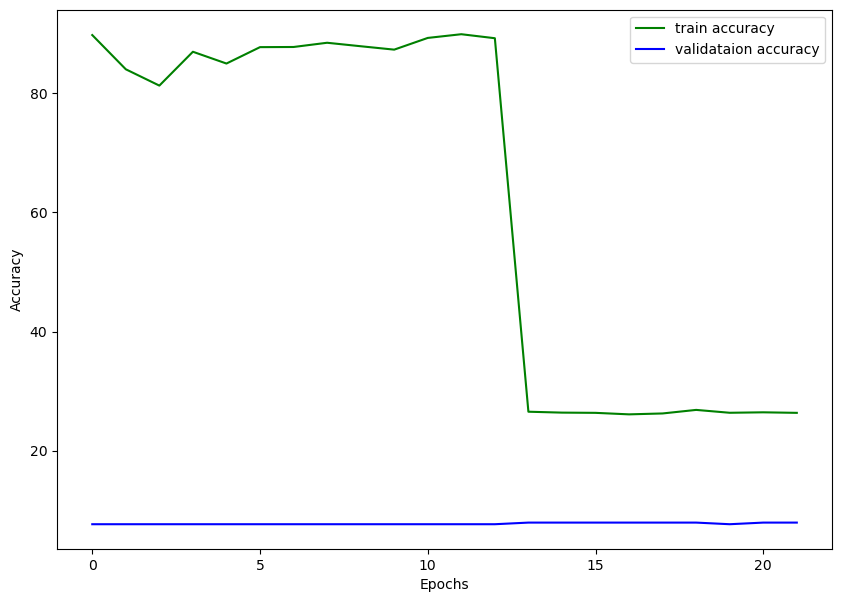

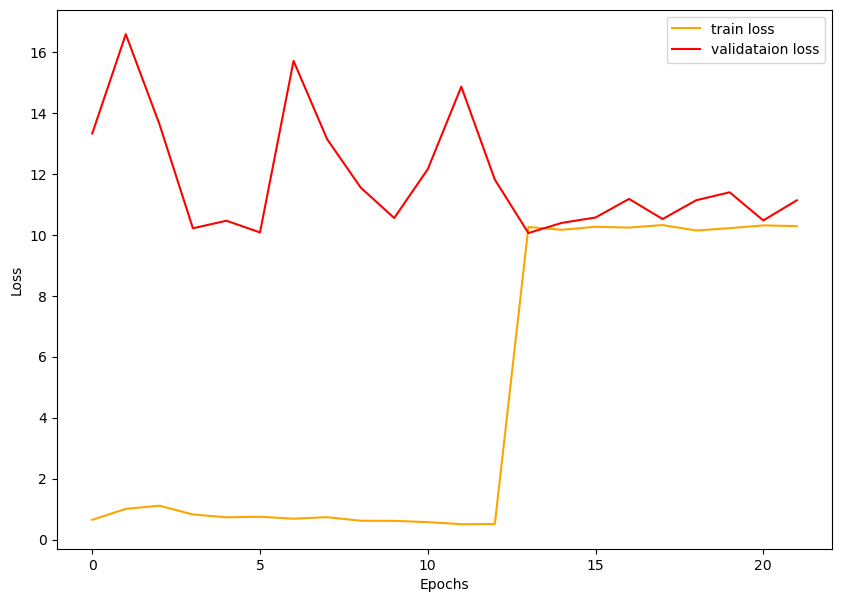

In [26]:
save_plots(train_acc, valid_acc, train_loss, valid_loss, "efficientnet_b4_dup_augData")